# Score Matching

A first important step is to realize that there's a convenient alternative to probability densities that let's us work with unnormalized functions: the so-called _score_. This is the name that was established for the gradient of the log likelihood function: $\nabla_x \log p(x)$. When we learn this function with a neural network, which we'll call $s_\theta(x)$ to indicate this is a learned _score_, the great thing is that we don't need to worry about normalization anymore. When integrating we'd need to have the right constant offset, but for the "local" gradients at $x$, all that matters is the derivative at this point.


## Gaussian Toy Dataset with Analytic Scores

We'll re-use the same Gaussian mixture case from the previous sections, but for experiments with the score function we'll expand the base class with a `score()` function so that we can check how well learned approximations fare. Luckily, we can compute the reference score directly from the Gaussian mixture model.

注，先解释一下本章说的score以及score matching的含义：
1. Score 是指对数概率密度函数的梯度，换句话说，Score是一个向量场，指向数据概率密度增加的方向。
2. 这里所指的近似，就是使用神经网络s来近似这个对数概率密度函数的梯度。
3. 为什么学习Score就不需要归一化了呢，这是因为Score是梯度，梯度本身和值的大小无关，具体的值的幅度会被消掉的。
4. 标题，Score Matching的含义就是指，使得神经网络尽可能匹配这个概率梯度，仅此而已。


In [2]:
import numpy as np

class GaussianMixture:
    def __init__(self, parameters):

        self.parameters = parameters
        self.distributions = [
            {
                'mean': np.array(dist['mean']),
                'std': np.array(dist['std']),
                'cov': np.diag(np.array(dist['std']) ** 2)
            }
            for dist in parameters
        ]

    def sample(self, num_samples):
        samples = []
        num_distributions = len(self.distributions)
        for _ in range(num_samples):
            idx = np.random.randint(num_distributions)
            dist = self.distributions[idx]
            sample = np.random.multivariate_normal(mean=dist['mean'], cov=dist['cov'])
            samples.append(sample)
        return np.array(samples)

    def likelihood(self, points):
        likelihoods = np.zeros(points.shape[0])
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            likelihoods += factor * np.exp(exponents)

        return likelihoods

    def score(self, points):

        scores = np.zeros_like(points)
        likelihoods = np.zeros(points.shape[0])

        component_likelihoods = []
        for dist in self.distributions:
            mean = dist['mean']
            cov = dist['cov']
            inv_cov = np.linalg.inv(cov)
            det_cov = np.linalg.det(cov)

            factor = 1 / (2 * np.pi * np.sqrt(det_cov))
            diff = points - mean
            exponents = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            comp_likelihood = factor * np.exp(exponents)

            component_likelihoods.append(comp_likelihood)
            likelihoods += comp_likelihood

        for dist, comp_likelihood in zip(self.distributions, component_likelihoods):
            mean = dist['mean']
            inv_cov = np.linalg.inv(dist['cov'])
            weights = comp_likelihood / (likelihoods + 1e-8)
            diff = points - mean
            component_score = -(diff @ inv_cov)
            scores += np.multiply(weights[:, np.newaxis], component_score)

        return scores

上面这段代码中的核心是增加了Score这个方法，例子还是选取的之前的高斯混合分布。
具体来讲，

Step1:其将分别遍历高斯分布的集合，计算每个数据点（或者说样本点）在该高斯分布组成（Component）的似然度（likehood），似然度是依靠当前高斯分布组成的均值、协方差矩阵，以及数据点间距离（内插值）来决定。

Step2:累加所有组成的似然度，获取每个Sample的总似然度。

Step3:计算权重，也就是 组件似然度 占 总似然度的比例。

Step4:计算每个高斯分布组成的梯度，即样本点相对于当前分布的均值的偏导数。

Step5:各组成的梯度 * 各组成的权重 = 总梯度，即总Score。

注：关于样本点相对于当前分布均值的偏导数，这具体指的是，样本点当前的似然函数值相对于均值的偏导数。

偏导数的计算指的是：如果均值（μ）发生变化，数据点 x 的概率密度会如何变化。这就是我们在得分计算中所做的事情——通过计算-(x - μ)^T Σ^{-1}，我们得到的是数据点x相对于模型参数μ的变化率。


### Visualizing Samples, Likelihoods and Scores

We'll also directly define a helper function that visualizes samples, the score field and the likelihood in a single graph:

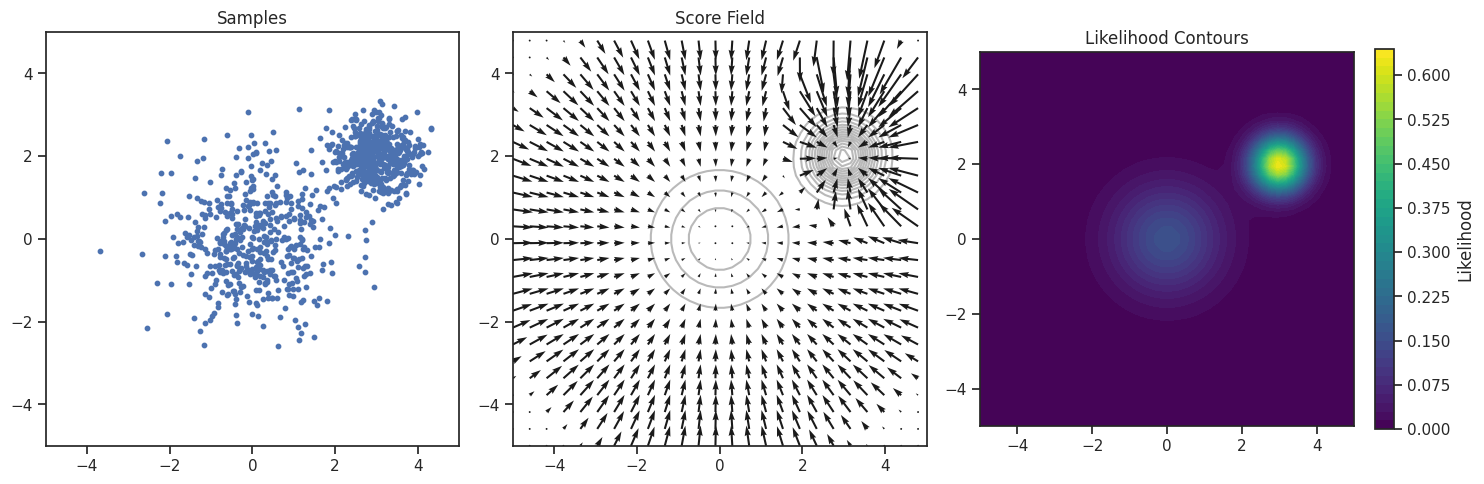

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

def visualize_gaussian_mixture_with_score(mixture, num_samples=1000, grid_size=50):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Create grid for visualization
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Compute likelihoods and scores
    likelihoods = mixture.likelihood(points)
    scores = mixture.score(points)
    samples = mixture.sample(num_samples)

    # Reshape for plotting
    likelihoods = likelihoods.reshape(grid_size, grid_size)
    scores_x = scores[:, 0].reshape(grid_size, grid_size)
    scores_y = scores[:, 1].reshape(grid_size, grid_size)

    ax1.scatter(samples[:, 0], samples[:, 1], s=10, alpha=1)
    ax1.set_title("Samples")

    skip = 2
    ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               scores_x[::skip, ::skip], scores_y[::skip, ::skip],
               scale=100, width=0.005)

    # Add likelihood contours to score plot for reference
    ax2.contour(X, Y, likelihoods, levels=20, colors='k', alpha=0.3)
    ax2.set_title("Score Field")

    # Plot likelihood contours
    contour = ax3.contourf(X, Y, likelihoods, levels=50, cmap='viridis')
    ax3.set_title("Likelihood Contours")
    plt.colorbar(contour, ax=ax3, label='Likelihood', fraction=0.046)

    # Plot score field
    # Subsample the grid for clearer arrows


    # Set consistent limits and labels
    for ax in [ax1, ax2, ax3]:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

parameters = [
    {"mean": [0, 0], "std": [1, 1]},
    {"mean": [3, 2], "std": [0.5, 0.5]}
]
mixture = GaussianMixture(parameters)
visualize_gaussian_mixture_with_score(mixture)

下面这段话讨论的其实是，原高斯分布比较难估计，主要有以下两点：

1. 原分布需要大量全局采样才能估计出来，这在高维空间中尤其难实现（高维空间难以均匀搜索）。

2. 估计原分布时，需要构造一个提议分布，并不断优化这个提议分布，然而，这个提议分布强制要求求和为1，这也是一个比较难以满足的条件。

简单总结来说：
原分布较难直接估计，但可以通过估计其梯度（得分）来简化问题。

具体来说，原分布（目标分布）的似然度通常比较难以直接估计，尤其是在高维空间中。为了解决这个问题，我们可以转而估计目标分布的得分（score function），即对数似然的梯度。这个方法的优势在于：

梯度只依赖于局部信息：计算得分只需要当前样本点和它的局部似然信息，而不需要全局的似然度估计。这样，在样本数目较少时，依然能获得有效的信息。

无需全局归一化：对于目标分布 p，我们可能需要对其进行归一化，确保它的积分为1（符合概率密度的标准要求）。但是，通过计算梯度（得分），我们避免了这个归一化的难题，因为得分本身只依赖于局部的概率密度，计算起来更加简便。

神经网络可以有效学习得分：由于得分仅依赖于局部信息，它非常适合通过神经网络进行学习。神经网络能够从样本中自动学习如何计算目标分布的得分，而不需要知道整个分布的完整形式。

It is important to keep in mind that we only know samples from the target distribution and we typically don't know the likelihood of the samples. It turns out that in this case it is much easier to obtain the score than the likelihood. Why is this the case?

To estimate the likelihood of a single individual sample, we need a large number of independent samples from the target distribution for comparison. The main difficulty here is that we have a proposal density $q_\theta$ for the target density $p$, then we need to make sure that if we integrate over the entire probability space, the result equals $1$, i.e. one of the standard requirements of densities $\int q_\theta(x)dx = 1$. To get the density of a single sample $x$ right, it needs to be normalized in the sense that the density still integrates to $1$.

With normalizing flows, this is always satisfied by the way the model and networks are constructed. However, as we have seen in the previous section, normalizing flows do not scale well to high dimensional data and are computationally expensive.

For general and flexible methods, making sure that the model $q_\theta$ integrates to 1 becomes extremely difficult.
What makes the score so interesting is that it depends on local information only. That means, because it considers the *gradient* of the log likelihood, its value only depends on the local values of the likelihood. This makes it much easier for a neural network to learn the score.

We will first explore how to learn the score from samples of the target distribution using a neural network. Then we will introduce a first method how to use the score to sample from the target distribution.

![Divider](https://github.com/tum-pbs/pbdl-book/blob/master/resources/divider-gen5.jpg?raw=1)

## Learning the Score

We could directly learn $\nabla_x \log p(x)$, the gradient of the log likelihood function, with an $L^2$ term. In this context, $L^2$ is  known as the "Fisher divergence": $\mathbb{E}_{x \sim p(x)} [||\nabla_x \log p(x) - s_\theta(x)||^2]$. However, this would require having access to the ground truth gradients $\nabla_x \log p(x)$?, which unfortunately is not the case for relevant settings. The trick established in ML to compute targets for learning is to slightly perturb the dataset with Gaussian noise {cite}`vincent2011dsm`. This turns it from a collection of point-wise samples into a continuous function of which we can compute the gradients.

So, for the dataset $\{ x_1, ..., x_n\}$￼ we consider the perturbed dataset ￼$\{ \tilde{x}_1, ..., \tilde{x}_n\}$ by adding Gaussian noise ￼$\tilde{x} = x + \sigma z$ with ￼$z \sim \mathcal{N}(0, I)$.
For now we keep the noise level ￼$\sigma > 0 $ fixed at a certain value, but this is a crucial parameter that we'll revisit soon.

We can write the perturbed distribution￼$p_\sigma$ that we get from the perturbed samples as a conditional distribution marginalized over the condition:
$p_\sigma(\tilde{x}) = \int p_\sigma(\tilde{x}|x) p(x) dx = \mathbb{E}_{x \sim p(x)}[p_\sigma(\tilde{x}|x)]$.
The smaller the noise level ￼￼$\sigma$ is, the closer the densities of the perturbed $p_\sigma$￼ and the original ones￼$p$ will be, i.e.
￼$\lim_{\sigma \to 0} \mathrm{KL}(p_\sigma||p) = 0$. Intuitively, we need the noise to compute a gradient, but it shouldn't be too large to distort the target distribution.

Now we can leverage the construction of the perturbed density with a Gaussian to compute the gradient for the score:
the conditional density  $p_\sigma(\tilde{x}|x)$￼has the analytic form

$$
    p_\sigma(\tilde{x}|x) = \frac{1}{\sqrt{(2\pi)^D \sigma^D}} \exp \left( - \frac{1}{2\sigma^2} (\tilde{x} - x)^T (\tilde{x} - x) \right) ,
$$ (p-perturbed)

and its score is surprisingly simple:

$$
    \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) = - \frac{\tilde{x} - x}{\sigma^2} .
$$ (score-perturbed)

We can train $s_\theta$￼ to approximate the score of the perturbed dataset with the conditional density using the identity

$$
\begin{aligned}
&\arg \min_\theta \mathbb{E}_{\tilde{x} \sim p_\sigma(\tilde{x})} \left[ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}) ||^2 \right] =
\\
&\arg \min_\theta \mathbb{E}_{x \sim p(x), \tilde{x} \sim p_\sigma(\tilde{x}|x)} \left[ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log p_\sigma(\tilde{x}|x) ||^2 \right]
\end{aligned}
$$

### Define Score Network and Dataset

To implement these ideas for our Gaussian mixture problem, we first define a simple score network with four hidden layers, and a dataset class that perturbs our samples as described above. The `DenoisingScoreMatchingDataset` class has a parameter `sigma` to control the amount of perturbation.

下面是使用4隐藏层来做估计。
下面的这个silu就是sigmoid 乘一个x即可。

In [4]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class ScoreNetwork(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.net(x)

class DenoisingScoreMatchingDataset(Dataset):
    def __init__(self, gaussian_mixture, num_samples=10000, sigma=0.1):
        self.samples = torch.FloatTensor(gaussian_mixture.sample(num_samples))
        self.sigma = sigma

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = self.samples[idx]

        noise = torch.randn_like(x) * self.sigma
        x_noisy = x + noise

        return x_noisy, noise, x

### Training

Now we can train the score network to estimate the gradients of the perturbed dataset, which are given by the perturbation in the dataset (`noise`) below, divided by $\sigma^2$.

注意，这里为什么要用perturbation，这个可以从前面可视化的真值那里来看，如果说你不加扰动，那么在远离分布中心的地方，基本是没有值的，换句话说，这些地方的梯度会非常地Chattering，导致难以收敛甚至无法计算，为此，加入高斯噪声后，等于加入了一个全局的高斯平滑，这样可以避免这些的梯度过于陡峭导致的错误。

有兴趣的话，可以试试把下面这段训练代码的sigma调为0，效果显而易见。


In [9]:
import torch
from torch import optim

def train_score_network(model, train_loader, num_epochs=100, sigma=0.1, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (x_noisy, noise, x_clean) in enumerate(train_loader):
            x_noisy, noise = x_noisy.to(device), noise.to(device)

            optimizer.zero_grad()

            pred_score = model(x_noisy)
            target_score = -noise / (sigma**2)
            loss = torch.mean(torch.sum((pred_score - target_score)**2, dim=1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return losses

# Create dataset and dataloader
dataset = DenoisingScoreMatchingDataset(mixture, num_samples=10000, sigma=0.1)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize and train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
score_net = ScoreNetwork().to(device)

losses = train_score_network(score_net, dataloader, num_epochs=100, device=device)

Epoch 10/100, Loss: 194.4301
Epoch 20/100, Loss: 196.4952
Epoch 30/100, Loss: 196.3101
Epoch 40/100, Loss: 199.7035
Epoch 50/100, Loss: 200.3670
Epoch 60/100, Loss: 196.5856
Epoch 70/100, Loss: 193.4999
Epoch 80/100, Loss: 193.6211
Epoch 90/100, Loss: 193.2173
Epoch 100/100, Loss: 197.0128


### Compare Learned and Reference Scores

Now that we have a trained network, let's qualitatively evaluate whether the predicted score is accurate or not. As shown above, we have a ground truth vector field for the score. The next cell plots it next to the one predicted by our trained network.

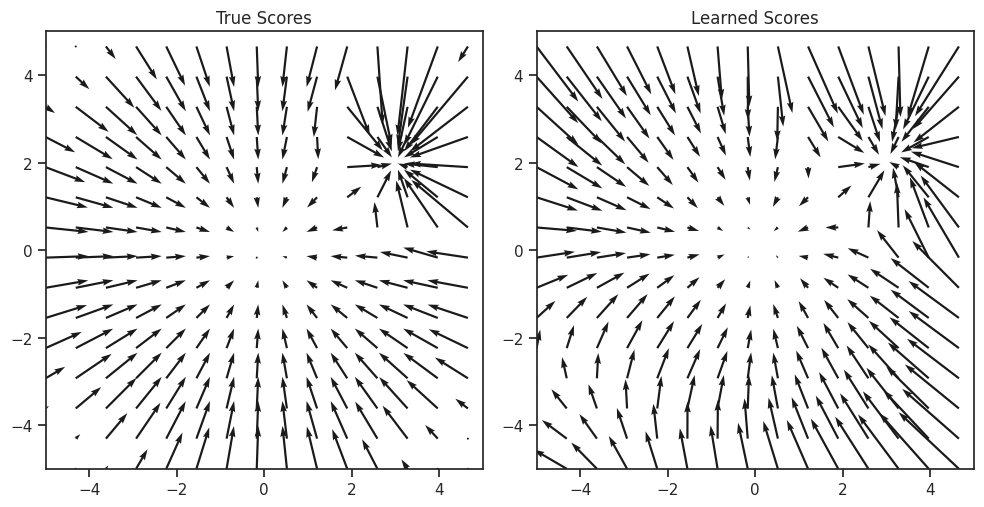

In [10]:
# Visualization function for learned scores
def visualize_learned_scores(mixture, score_net, grid_size=30, device='cpu'):
    """
    Visualize true and learned scores side by side
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Create grid for visualization
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack([X.ravel(), Y.ravel()])

    # Compute true scores
    true_scores = mixture.score(points)
    true_scores_x = true_scores[:, 0].reshape(grid_size, grid_size)
    true_scores_y = true_scores[:, 1].reshape(grid_size, grid_size)

    # Compute learned scores
    score_net.eval()
    with torch.no_grad():
        learned_scores = score_net(torch.FloatTensor(points).to(device)).cpu().numpy()
    learned_scores_x = learned_scores[:, 0].reshape(grid_size, grid_size)
    learned_scores_y = learned_scores[:, 1].reshape(grid_size, grid_size)

    # Plot true scores
    skip = 2
    ax1.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               true_scores_x[::skip, ::skip], true_scores_y[::skip, ::skip],
               scale=50, width=0.005)
    ax1.set_title("True Scores")

    # Plot learned scores
    ax2.quiver(X[::skip, ::skip], Y[::skip, ::skip],
               learned_scores_x[::skip, ::skip], learned_scores_y[::skip, ::skip],
               scale=50, width=0.005)
    ax2.set_title("Learned Scores")

    # Set consistent limits and labels
    for ax in [ax1, ax2]:
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_xlabel("")
        ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_learned_scores(mixture, score_net, device=device)

This motivates the non-trivial construction via the perturbed, conditional density: all steps required in the second equation can be computed efficiently. Hence, this gives a practical method for learning score functions, provided that we know a suitable value for $\sigma$.

This leads us to the next step, let's assume we have successfully trained  our network, how can we use ￼$\nabla_{\tilde{x}} \log p_\sigma(\tilde{x})$
to obtain a generative model for $p(x)$￼? That is, how can we produce actual samples $x$ with the score?

注，上面我们提到，要正确计算全局梯度，需要有一定的扰动，而要把这个梯度用到分布估计上，我们引入了如下所示的郎之万动力学，为什么用这个呢，因为郎之万动力学有两项，一项为漂移项，可以直接由梯度引导，另一项则显式表征了噪声项，这就可以直接由环境噪声表征。


## Langevin Dynamics

To arrive at a practical method, we turn to _Langevin Dynamics_. They're traditionally used for molecular systems with deterministic and stochastic forces.
It was shown there that iteration steps along the score, with just the right amount of additional perturbation at each step actually converge to samples from $p(x)$.

Specifically, for the update

$$
    x_{i+1} \leftarrow x_i + \epsilon \nabla_x \log p(x) + \sqrt{2 \epsilon} z_i
$$ (langevin)

with  $i = 0,1,..., K$  and  $z_i \sim \mathcal{N}(0, I)$,
the iterate $x_K$ converges to a sample from $p(x)$￼ as  $K \to \infty$  and $\epsilon \to 0$  under a set of regularity conditions.
For the theory, we should also consider how  $x_0$ was sampled from a distribution for  initialization, typically called￼ $\pi(x)$.
For updating $x_i$, we can of course make use of the trained network $s_\theta$ to obtain the score $\nabla_x \log p(x)$ in each step of the iteration.


### Langevin Dynamics Algorithm

Let's give this a try with our score function! The `langevin_dynamics` function below implements the integration steps for a varying number of steps (0 to 500) to show how it converges. We're starting with points on a dense regular grid, to show whether (and how) points from all over domain move towards the densities of the underlying distribution via the score gradients.

基于郎之万动力学的生成式方法，可以从score函数中生成样本，简单来讲，是利用Score信息来引导随机游走，使其收敛到数据分布的高概率区域。

朗之万动力学是一种典型的机理式生成方法，它：

基于统计物理原理

通过模拟粒子在概率景观中的随机动力学来生成样本

具有清晰的物理解释和理论保证

与深度学习结合时，用神经网络学习score函数，但采样过程仍保持机理特性。

In [11]:
def langevin_dynamics(score_net, n_steps=1000, n_samples=35, step_size=0.01):

    device = next(score_net.parameters()).device

    x = torch.linspace(-5, 5, n_samples)
    y = torch.linspace(-5, 5, n_samples)
    X, Y = torch.meshgrid(x, y)
    x = torch.stack([X.flatten(), Y.flatten()], dim=1)

    x = x.to(device)

    trajectory = [x.cpu().detach().numpy()]

    score_net.eval()
    with torch.no_grad():
        for step in range(n_steps):

            score = score_net(x)
            noise = torch.randn_like(x)
            x = x + step_size * score + np.sqrt(2 * step_size) * noise

            if step in [0, 100, 200, 300, 400, 500]:
                trajectory.append(x.cpu().detach().numpy())

    return trajectory


trajectory = langevin_dynamics(
    score_net,
    n_steps=501,    # run for 501 steps to include step 500
    n_samples=35,
    step_size=0.01,
)

samples =  trajectory[-1]

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Visualize the Trajectories

Having the sample points ready in the `samples` array, we can visualize them as colored dots over the score contours. We'll color the initial grid setup with a smooth RGB gradient, so that the colors of dots later on show where initial positions have ended up across the target density landscape.

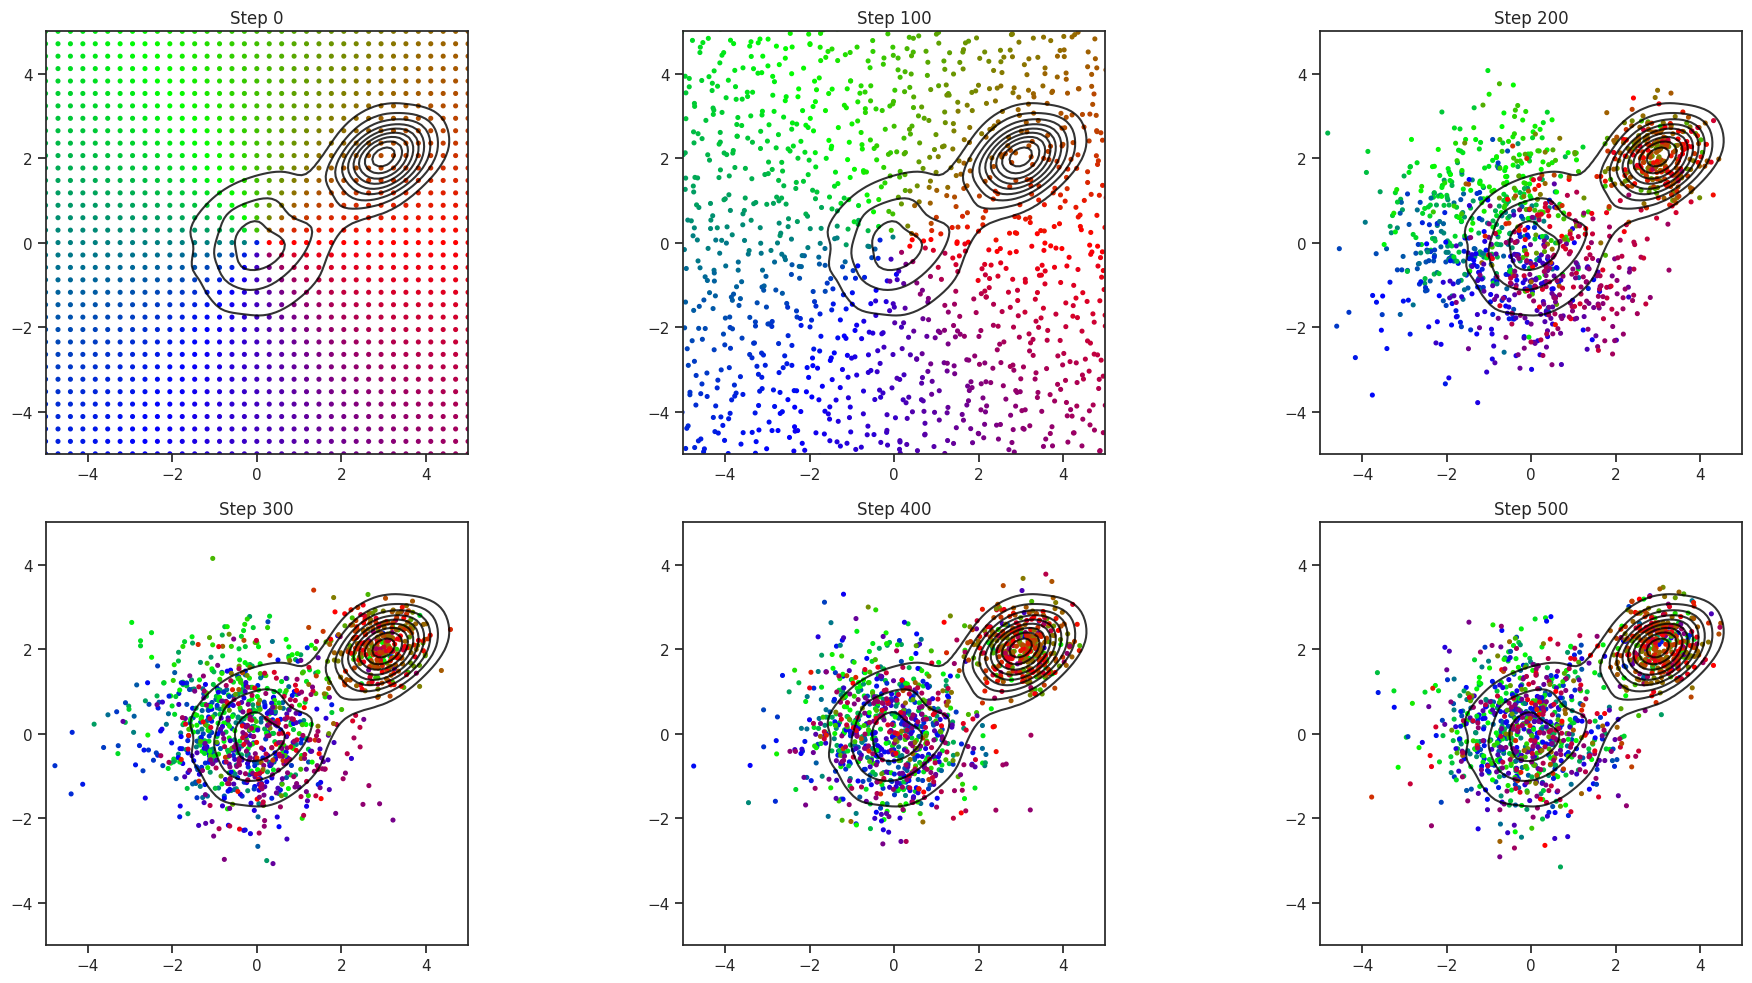

In [12]:
def get_angle_colors(positions):
    angles = np.arctan2(positions[:, 1], positions[:, 0])
    angles_deg = (np.degrees(angles) + 360) % 360
    colors = np.zeros((len(positions), 3))
    for i, angle in enumerate(angles_deg):
        segment = int(angle / 120)
        local_angle = angle - segment * 120
        if segment == 0:    # 0 degrees to 120 degrees (R->G)
            colors[i] = [1 - local_angle/120, local_angle/120, 0]
        elif segment == 1:  # 120 degrees to 240 degrees (G->B)
            colors[i] = [0, 1 - local_angle/120, local_angle/120]
        else:               # 240 degrees to 360° (B->R)
            colors[i] = [local_angle/120, 0, 1 - local_angle/120]

    return colors

def visualize_langevin_trajectory(trajectory, mixture, figsize=(20, 10)):

    n_plots = len(trajectory)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()
    real_samples = mixture.sample(1000)
    from scipy.stats import gaussian_kde
    xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    kernel = gaussian_kde(real_samples.T)
    density = np.reshape(kernel(positions).T, xx.shape)

    steps = [0, 100, 200, 300, 400, 500]

    for idx, (samples, step) in enumerate(zip(trajectory, steps)):
        ax = axes[idx]

        if idx == 0:
            c = get_angle_colors(samples)

        ax.contour(xx, yy, density, levels=10, alpha=0.8, colors='black')
        ax.scatter(samples[:, 0], samples[:, 1], alpha=1, s=7, color=c)

        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_title(f'Step {step}')

    plt.tight_layout()
    plt.show()

visualize_langevin_trajectory(trajectory, mixture)

This seems to work well! The regularly spaced points correctly move towards the higher density regions, and the reddish points on the right primarily end up in the high-density cluster on the right side, while other points (blue, green and red all mixed) end up in the lower density peak in the center.

## Annealed Langevin Dynamics

While this provably converges in the limit, it causes some difficulties in practice: the approach requires a fairly large amount of noise $\sigma$ to ensure the gradients actually "lead" the samples towards the correct targets. If $\sigma$ is too small, we won't have a score (no direction from the gradient), and if it's too large, the overlapping Gaussians will reduce the quality of our data samples (drowning important details in noise).

Considering the space of all $x$ we get from $\pi(x)$, increasing noise levels $\sigma$ of the perturbed dataset will cover larger regions of the perturbed data space. This will give gradients wherever we start out,
and is important in practice: we shouldn't have to make a lot of assumptions to find good initial points for our iterations. This would only shift the problem from generating the outputs to generating suitable inputs for the algorithm. This is way many classic works need to carefully specify prior distributions to make sure the algorithms converge. It's a delicate balance: working with large $\sigma$ is important for practical applications,
but if the perturbation is too large we have $p(x) \not\approx p_\theta(x) $
and the samples we produce will be useless in the worst case.

This poses the question: why should we be restricted to a single $\sigma$?
It turns out that we can resolve the problem of _no score VS bad quality_ by going from large to small amounts of noise.
Let's consider multiple noise scales $0 < \sigma_1 < \sigma_2 < ... < \sigma_L$ , giving what's known as _Annealed Langevin Dynamics_.
(Looking ahead, this also bring us closer to a central topic in the area of diffusion models: the different and changing levels of noise.)

We repeatedly apply Langevin Dynamics for each noise scale, starting from the largest noise $\sigma_L$￼ until the smallest noise ￼$\sigma_1$, and
train a network $s_\theta(x, \sigma_j)$￼ with the noise scale $\sigma_j$ as an additional input.
Now we can iterate over $x_i$, and while updating it we also use smaller and smaller $\sigma_j$ to make sure we converge to an accurate sample $x \sim p_\theta(\tilde{x}) $.

### Network and Dataset Definition with Noise Level

Let's implement this idea. First, we need to modify our score network to be aware of the noise level. For this, it will receive an additional parameter $\sigma$ as input. Likewise, our dataset is extended to cover different amounts of noise.

模拟退火郎之万动力学

这很巧妙地解决了刚才提出的问题，即，噪声水平过小，会导致大多数区域无梯度；噪声水平过大，会导致最终收敛的精度不高；所以我们就选择把多个噪声水平都训练一次，然后使用高噪声的先算初值，然后逐步降低噪声水平，使得采样点既可以平滑收敛，又可以最终到一个较高的精度。


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ScoreNetworkWithSigma(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for sigma
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, sigma):
        sigma = sigma.view(-1, 1)
        x_sigma = torch.cat([x, sigma], dim=1)
        return self.net(x_sigma)

class AnnealedDenoisingScoreMatchingDataset(Dataset):
    def __init__(self, gaussian_mixture, num_samples=10000, sigmas=[4.0, 2.0, 1.0, 0.5, 0.2, 0.01]):
        self.samples = torch.FloatTensor(gaussian_mixture.sample(num_samples))
        self.sigmas = sigmas

    def __len__(self):
        return len(self.samples) * len(self.sigmas)

    def __getitem__(self, idx):
        sample_idx = idx // len(self.sigmas)
        sigma_idx = idx % len(self.sigmas)

        x = self.samples[sample_idx]
        sigma = self.sigmas[sigma_idx]

        # Add noise to the sample
        noise = torch.randn_like(x) * sigma
        x_noisy = x + noise

        return x_noisy, noise, x, torch.tensor(sigma).float()

### Training

With these two ingredients, training proceeds just like before...

In [14]:
def train_annealed_score_network(model, train_loader, num_epochs=100, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_idx, (x_noisy, noise, x_clean, sigma) in enumerate(train_loader):
            x_noisy, noise = x_noisy.to(device), noise.to(device)
            sigma = sigma.to(device)

            optimizer.zero_grad()

            pred_score = model(x_noisy, sigma)

            target_score = -noise / (sigma.view(-1, 1) ** 2)
            loss = torch.mean(torch.sum((pred_score - target_score) ** 2, dim=1))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return losses

sigmas = [4.0, 2.0, 1.0, 0.5, 0.2, 0.01]

dataset = AnnealedDenoisingScoreMatchingDataset(mixture, num_samples=10000, sigmas=sigmas)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
score_net = ScoreNetworkWithSigma().to(device)

losses = train_annealed_score_network(score_net, dataloader, num_epochs=100, device=device)

Epoch 10/100, Loss: 3301.3321
Epoch 20/100, Loss: 3370.4934
Epoch 30/100, Loss: 3293.7949
Epoch 40/100, Loss: 3324.8768
Epoch 50/100, Loss: 3371.3887
Epoch 60/100, Loss: 3318.8659
Epoch 70/100, Loss: 3332.7754
Epoch 80/100, Loss: 3337.8393
Epoch 90/100, Loss: 3344.8067
Epoch 100/100, Loss: 3359.1922


For sampling with Langevin Dynamics and varying noise levels, we modify the sampling process to reduce the $\sigma$ values step by step, and then leverage the noise-aware score network to provide the right gradients.

In [15]:
def annealed_langevin_dynamics(score_net, sigmas,
                               n_steps_each=100, n_samples=1000,
                               step_size=0.001):
    device = next(score_net.parameters()).device

    x = torch.linspace(-10, 10, n_samples)
    x = torch.stack(torch.meshgrid(x, x), dim=-1).reshape(-1, 2)

    x = x.to(device)

    trajectory = [x.cpu().detach().numpy()]

    score_net.eval()
    with torch.no_grad():
        for sigma in sigmas:
            alpha = step_size * (sigma / sigmas[-1]) ** 2

            for step in range(n_steps_each):
                sigma_tensor = torch.full((n_samples*n_samples,), sigma, device=device)
                score = score_net(x, sigma_tensor)

                noise = torch.randn_like(x)
                x = x + alpha * score + np.sqrt(2 * alpha) * noise

            trajectory.append(x.cpu().detach().numpy())

    return trajectory

trajectory = annealed_langevin_dynamics(
        score_net,
        sigmas=sigmas,
        n_steps_each=150,
        n_samples=35,
        step_size=0.00001
        )

### Visualization of Trajectories

Now we can finally visualize the trajectories. In addition to the moving sample locations, the contours of the underlying score function will now change correspondingly with the varying $\sigma$ perturbations.

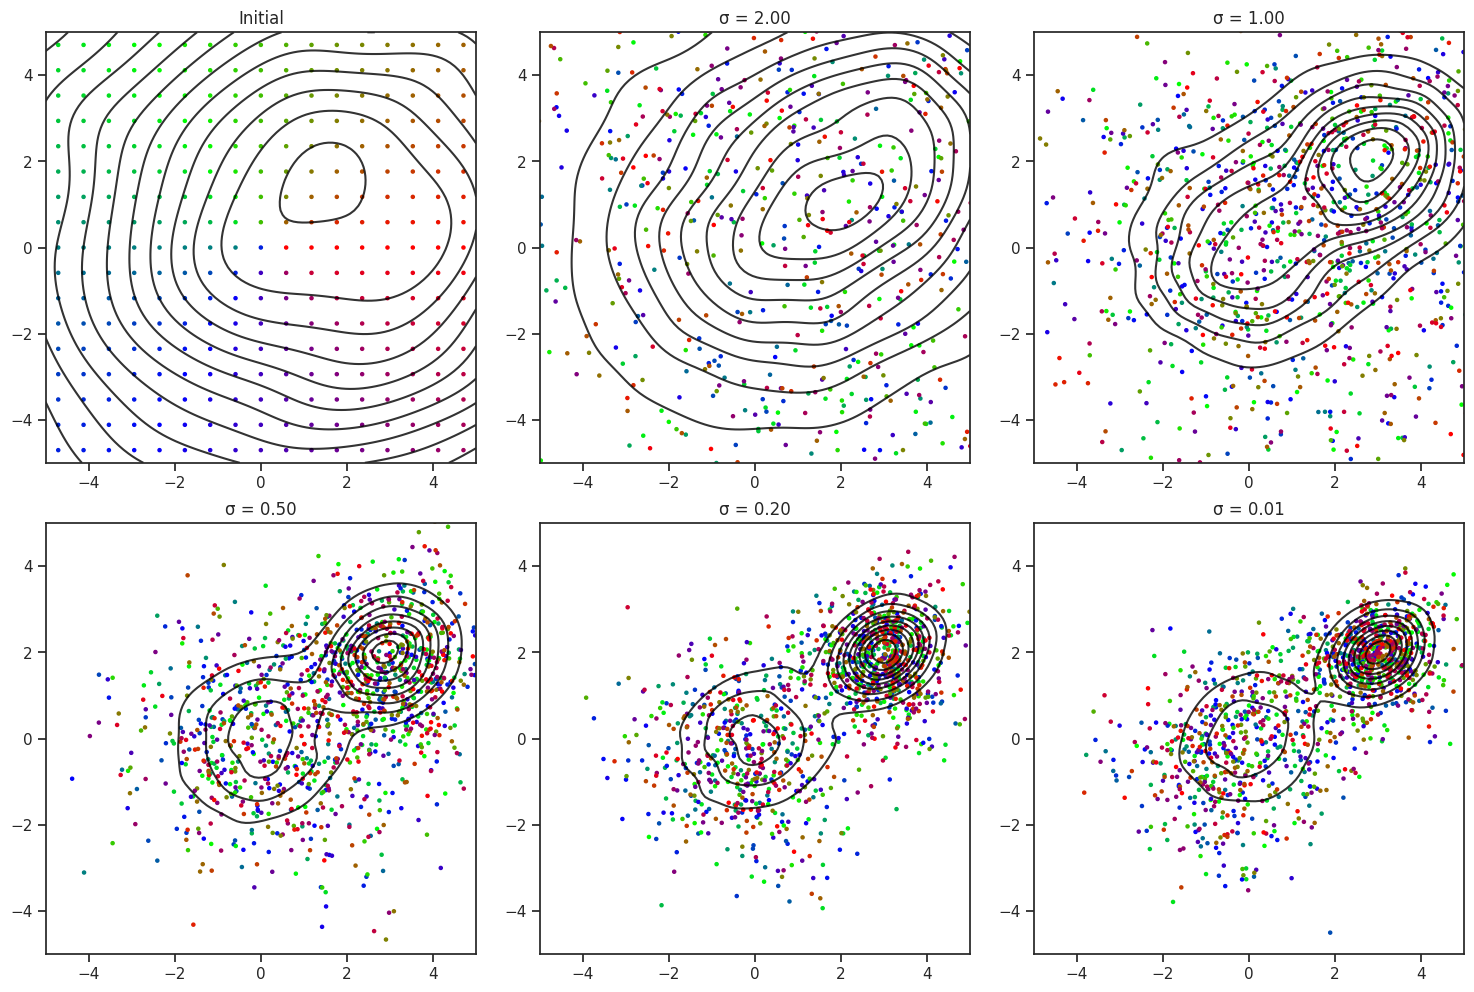

In [16]:
def visualize_annealed_langevin_trajectory(trajectory, mixture, sigmas, figsize=(15, 10)):

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()

    from scipy.stats import gaussian_kde
    xx, yy = np.mgrid[-5:5:100j, -5:5:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    for idx, (samples, sigma) in enumerate(zip(trajectory, sigmas)):
        ax = axes[idx]

        if idx == 0:
            c = get_angle_colors(samples)

        real_samples = torch.tensor(mixture.sample(5000))
        real_samples += torch.randn_like(real_samples) * sigma

        kernel = gaussian_kde(real_samples.T)
        density = np.reshape(kernel(positions).T, xx.shape)

        ax.contour(xx, yy, density, levels=10, alpha=0.8, colors='black')

        ax.scatter(samples[:, 0], samples[:, 1], alpha=1.0, s=5, color=c)

        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_aspect('equal')
        ax.set_title(f'σ = {sigma:.2f}' if idx > 0 else 'Initial')

    plt.tight_layout()
    plt.show()

visualize_annealed_langevin_trajectory(trajectory, mixture, sigmas)


These plots nicely show how we start with a very smoothly varying score function, as shown by the wide contour lines, towards the sharper peaks of the target distribution.
The annealing successfully removes the need for a manually prescribed perturbation.


## Score Summary

Now we're almost at the goal, but before making the last step to derive the famous "denoising" task, let's summarize the ground we've covered so far:
* Denoising score matching works well even for high-dimensional data such as images.
* There's no need to backpropagate gradients through many steps, i.e. the method is much more scalable than CNFs or NeuralODEs.
* We have a way to sample from $p(x)$ to produce samples without the need for assumptions in the form of non-trivial prior distributions.

Despite these important steps forward, we're left with a few challenging aspects:
* Specifying a good sequence of noise scales is critical, and unclear to obtain so far.
* We can sample from $p(x)$, but not directly compute likelihoods.
* The "convenient" maximum likelihood training is not applicable anymore.

There's also the practical aspect of performance: inference actually requires many evaluations of $s_\theta(x, \sigma_j)$, and this can make producing samples expensive. As a first step, we'll make sure we can get _accurate_ samples, but we'll also revisit the question of computational efficiency later on.

总结：

本章节针对的其实是生成式神经网络的讨论。

一般目前有三类方法，VAE,GAN,Diffusion。

首先是VAE,VAE显然来自于AE，而AE不能用于生成式的原因是，AE总是把输入投射到一个点上，换句话说，他的特征隐空间是离散的，那如果后续输入一个训练集中不存在的点，那么AE就会输出毫无意义的东西；为了解决这一问题，VAE将特征隐空间改为了高斯混合分布，这使得训练集会被映射到多个高斯分布上，而训练集中不存在的点在推理时，也会落在多个高斯分布的交界处，这使得输出有了意义；但是显而易见的问题是，多个高斯分布融合的位置，生成效果不会太好，所以VAE的生成特点是，较为模糊，缺少细节。

第二是GAN-based 方法，包含了GAN与cGAN,这类方法是依靠对抗最优进行训练的，这会在DG博弈中逐渐学到细节，但是也因为其逐样本训练的问题，训练过程不稳定；GAN和cGANd都是随机噪声中采样出来的输入，cGAN多embed了一个condition而已，因此，其隐空间一般被认为是连续的（因为随机噪声是从高斯分布中采样出来的，所以认为是连续的）

第三则是Diffusion-based的 Method，最基础的形式就是本节所述的 Score-Matching + 郎之万动力学；前面高斯混合模型还有一个问题是，其要求神经网络，也就是用于估计高斯混合分布的网络，求和为1，这种强制要求会导致模型泛化性下降；

为此，得分匹配不再估计原始分布，而是去估计原始分布的导数，那这就带来新的问题，第一，远离分布中心的数据点，值接近0，梯度跳动巨大；第二，Score-Matching只有梯度，尚未回到实际的分布。

对于问题1，可以加入高斯噪声解决，高斯噪声本质上是一个均值为0的高斯平滑，这就可以为全局施加一个平滑梯度，避免了梯度跳动。

对于问题2，郎之万动力学被引入解决。

当然，问题1+问题2还带来了问题3，就是噪声和精度的trade-off，所以如本节前文所述，这里引入了模拟退火方法，逐渐降低噪声水平，使得模型既能引导，又能最终收敛到噪声较小的结果中。

后记

其实这种模拟退火形式的方法还挺有哲学的，离目标远的时候，不要看那么清楚，看得太清楚脚下就没路了，要取下眼镜看模糊；离目标近的时候，要看清楚，这样才能最终收敛到自己需要的目标。